In [22]:
from kafka import KafkaConsumer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from json import dumps
import numpy as np
import pickle

from sklearn.metrics import classification_report,accuracy_score

import pickle


In [23]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [24]:
for m in consumer:
        m.value
        break

In [25]:
def get_1000_rec(itr):
    list_of_1000_rec=[]
    i=0
    for c in consumer:

        if i <1000:
            list_of_1000_rec.append(c.value)
            i=i+1
        else:

            break
    print(f"Window {itr}")


    return list_of_1000_rec


In [26]:
col_names =["timestamp","FQDN_count","subdomain_length","upper","lower","numeric","entropy","special","labels","labels_max","labels_average","longest_word","sld","len","subdomain","Target Attack"]
def adjust_data( data):
    dataframe=pd.DataFrame()
    list_of_rows=[]
    for item in data:
        row_string=eval(item.decode("UTF-8"))
        row_string = row_string.strip()
        row= row_string.split(",")
        list_of_rows.append(row)
    dataframe=pd.DataFrame(list_of_rows)
    dataframe.columns=col_names
    return dataframe

In [27]:
def cleaning_the_data(data):
    data['longest_word'] = data['longest_word'].replace(r'(([a-z]+)|([A-Z]+)|'')',2, regex=True)
    data['longest_word'].fillna(2,inplace=True)
    data['sld'] = data['sld'].replace(r'(([a-z]+)|([A-Z]+|(0-1)))',192, regex=True)
    data['sld']=data['sld'] .astype('int')
    data.drop('timestamp', inplace=True, axis=1)
    return data.astype('float')

In [28]:
def retrain(data):

    pipe = Pipeline(steps=[("MI with RF",SelectKBest(score_func=mutual_info_classif, k=8)), ("RandomForestClassifier", RandomForestClassifier())])
    X =data.drop(labels = ["Target Attack"], axis=1)
    y=data["Target Attack"]
    pipe.fit(X,y)
    return pipe

In [29]:
pickle.load(open('model.pkl', 'rb'))

Pipeline(steps=[('feature_selection',
                 SelectKBest(k=8,
                             score_func=<function mutual_info_classif at 0x7f50b743c040>)),
                ('classifier',
                 RandomForestClassifier(n_estimators=50, random_state=42))])

In [30]:
static_model = Dynamic_model= pickle.load(open('model.pkl', 'rb'))

In [31]:
training_data=cleaning_the_data(adjust_data(get_1000_rec(0)))
list_of_f1_Dynmaic_model=[]
list_of_f1_static_model=[]
for itr in range(1,200):
    r_dataset = get_1000_rec(itr)
    p_dataset =  adjust_data(r_dataset)
    new_dataset =  cleaning_the_data(p_dataset)
    X =new_dataset.drop(labels = ["Target Attack"], axis=1)
    y=new_dataset["Target Attack"]

    Dy_pred=Dynamic_model.predict(X)
    D_f1=accuracy_score(y,Dy_pred)
    print(f"The F1 Score of Dynamic Model without retrain = {D_f1*100}%")
    if D_f1 < 0.81 :

        print(" trained model on the new data")
        Dynamic_model=retrain(training_data)
        Dy_pred=Dynamic_model.predict(X)
        D_f1=accuracy_score(y,Dy_pred)
        print(f"The f1 of Dynamic Model after retrain = {D_f1*100}%")
    training_data=pd.concat([training_data,new_dataset])
    Sy_pred=static_model.predict(X)
    S_f1=accuracy_score(y,Sy_pred)
    print(f"The F1 of Static Model = {S_f1*100}%")
    list_of_f1_Dynmaic_model.append(D_f1)
    list_of_f1_static_model.append(S_f1)
    print(f"{'*'*10}")


Window 0
Window 1
The F1 Score of Dynamic Model without retrain = 81.6%
The F1 of Static Model = 81.6%
**********
Window 2
The F1 Score of Dynamic Model without retrain = 79.60000000000001%
 trained model on the new data
The f1 of Dynamic Model after retrain = 79.80000000000001%
The F1 of Static Model = 79.60000000000001%
**********
Window 3
The F1 Score of Dynamic Model without retrain = 81.39999999999999%
The F1 of Static Model = 81.69999999999999%
**********
Window 4
The F1 Score of Dynamic Model without retrain = 80.0%
 trained model on the new data
The f1 of Dynamic Model after retrain = 80.4%
The F1 of Static Model = 80.7%
**********
Window 5
The F1 Score of Dynamic Model without retrain = 80.9%
 trained model on the new data
The f1 of Dynamic Model after retrain = 81.0%
The F1 of Static Model = 81.10000000000001%
**********
Window 6
The F1 Score of Dynamic Model without retrain = 80.80000000000001%
 trained model on the new data
The f1 of Dynamic Model after retrain = 80.8000000

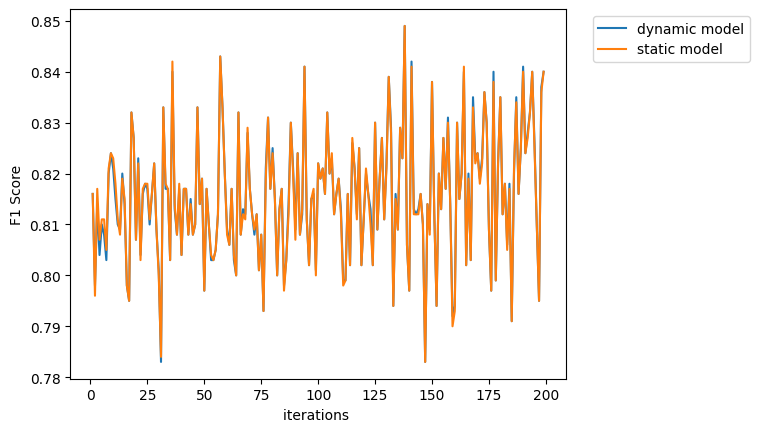

In [32]:
import matplotlib.pyplot as plt
plt.plot(range(1, 200), list_of_f1_Dynmaic_model, label=f'dynamic model')
plt.plot(range(1, 200),list_of_f1_static_model, label=f'static model')
plt.xlabel('iterations ')
plt.ylabel("F1 Score")
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")